## Modeling Vehicle Fuel Consumption Based on Car Specifications  
### Logistic Regression Built from First Principles

In [78]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import boxcox


import sys
sys.path.append('..')

from models.linear_models.logistic_regression import LogisticRegression

In [79]:
import os
df = pd.read_csv(os.path.join('..', 'data', 'raw', 'diabetes.csv'))
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [80]:
df.replace("?", np.nan,inplace=True)
# Missing value analysis
missing = df.isna().sum()
for col, val in missing.items():
    print(col,val)

Pregnancies 0
Glucose 0
BloodPressure 0
SkinThickness 0
Insulin 0
BMI 0
DiabetesPedigreeFunction 0
Age 0
Outcome 0


In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def feature_selection(df, target="Outcome", target_threshold=0.05, inter_feat_threshold=0.9):
    # 1. Correlation with target
    corr_matrix = df.corr()
    corr_target = corr_matrix[target].abs()
    
    
    # Get features that meet the threshold
    strong_features = corr_target[corr_target >= target_threshold].index.tolist()
    
   
    plt.figure(figsize=(5, 10))
    # Formatting as a DataFrame so heatmap can plot it
    sns.heatmap(corr_target.to_frame().sort_values(by=target, ascending=False), 
                annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title(f'Correlation with {target}')
    plt.show()

    print(f"Keeping strong features: {strong_features}")
    df_filtered = df[strong_features]
    
    # 2. Remove multicollinear predictors
    if target in df_filtered.columns:
        predictors = df_filtered.drop(columns=[target])
    else:
        predictors = df_filtered

    corr_predictors = predictors.corr().abs()
    
    # Consider upper triangle only to avoid double-dropping
    upper_triangle = corr_predictors.where(
        np.triu(np.ones(corr_predictors.shape), k=1).astype(bool)
    )
    
    to_drop = [col for col in upper_triangle.columns 
               if any(upper_triangle[col] >= inter_feat_threshold)]
    
    print(f"Dropping redundant features: {to_drop}")
    df_final = df_filtered.drop(columns=to_drop)
    
    return df_final

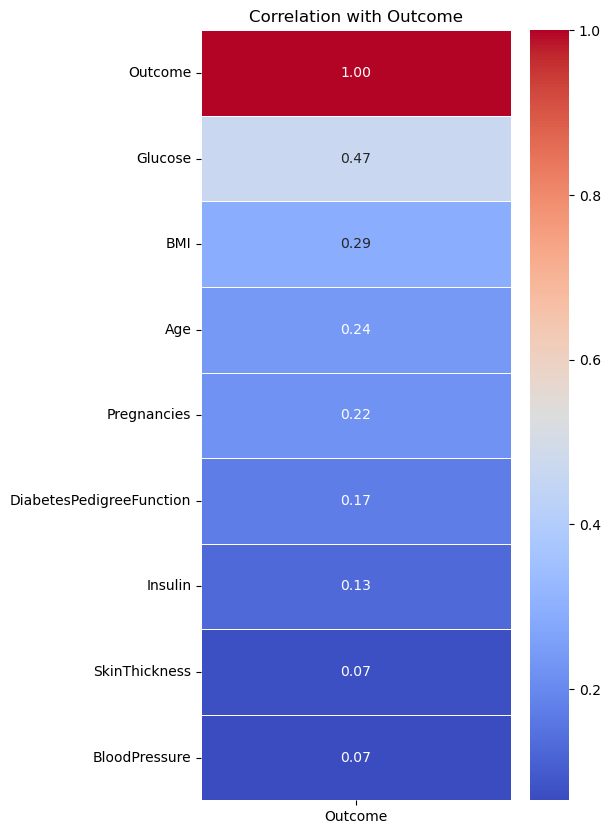

Keeping strong features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Dropping redundant features: []


In [82]:
df_clean = feature_selection(df)

In [83]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


def preprocessing_pipeline(df):
    numeric_cols = df.select_dtypes(include=np.number).columns
    cat_columns = df.select_dtypes(include=['object']).columns
    
    numeric_transformer = Pipeline(steps=[
        ('imputer',SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer',SimpleImputer(strategy='most_frequent')),
        ('onehot',OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ('num',numeric_transformer,numeric_cols),
        ('cat',categorical_transformer,cat_columns)
    ])
    
    return preprocessor.fit_transform(df)
    

In [84]:
from sklearn.model_selection import train_test_split

X = df_clean.drop(columns="Outcome")
y = df_clean["Outcome"]

X_transformed = preprocessing_pipeline(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed,y,test_size=0.2,stratify=y,random_state=42)

model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

accuracy_score = model.score(X_test,y_test)
print("Accuracy score", accuracy_score)

Iteration 100/1000 - Loss: 0.6024
Iteration 200/1000 - Loss: 0.5566
Iteration 300/1000 - Loss: 0.5305
Iteration 400/1000 - Loss: 0.5141
Iteration 500/1000 - Loss: 0.5030
Iteration 600/1000 - Loss: 0.4951
Iteration 700/1000 - Loss: 0.4893
Iteration 800/1000 - Loss: 0.4849
Iteration 900/1000 - Loss: 0.4815
Iteration 1000/1000 - Loss: 0.4789
Accuracy score 0.7077922077922078
